In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing import image
import random
import pandas as pd
import os

In [2]:
train_fractured_dir=r"data\train\fractured"
train_not_fractured_dir=r"data\train\not fractured"
val_fractured_dir=r"data\val\fractured"
val_not_fractured_dir=r"data\val\not fractured"

In [3]:
len(train_not_fractured_dir)

24

In [4]:
folder_path=train_fractured_dir
image_extensions=['.jpg']
image_count=len([f for f in os.listdir(folder_path) 
if os.path.isfile(os.path.join(folder_path, f)) and os.path.splitext(f)[1].lower() in image_extensions])

print(image_count)

4480


In [5]:
def count_images(directory):
    return len(os.listdir(directory))

train_fractured_count=count_images(train_fractured_dir)
train_not_fractured_count=count_images(train_not_fractured_dir)
val_fractured_count=count_images(val_fractured_dir)
val_not_fractured_count=count_images(val_not_fractured_dir)


In [6]:

print(train_fractured_count)
print(train_not_fractured_count)
print(val_fractured_count)
print(val_not_fractured_count)

4480
4383
360
240


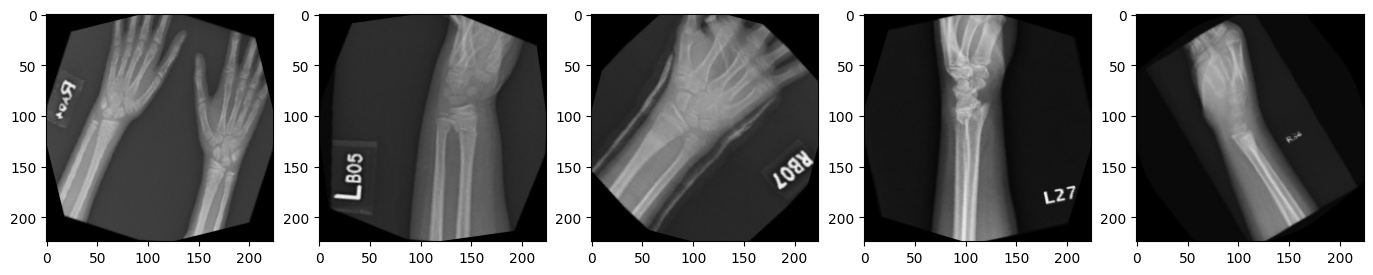

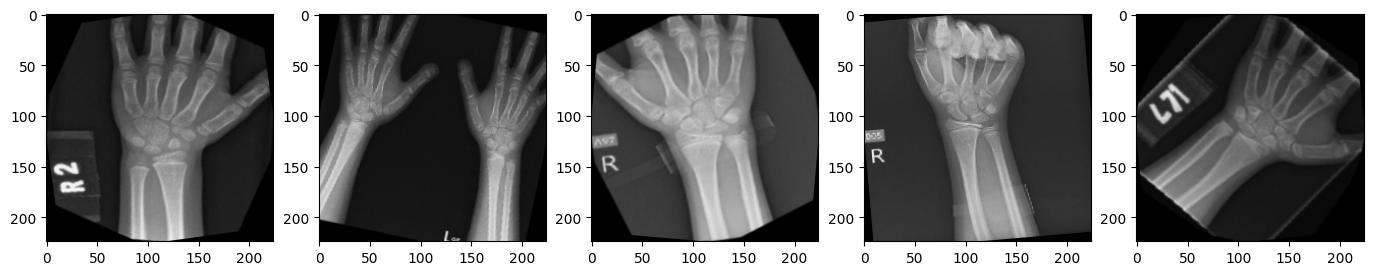

In [7]:
def show_pics(folder_path,num=5):
    pics=os.listdir(folder_path)
    chosen_pics=random.choices(pics,k=num)
    plt.figure(figsize=(17,7))
    
    for index,pic in enumerate(chosen_pics):
        pic_path=os.path.join(folder_path,pic)
        img=plt.imread(pic_path)
        plt.subplot(1,num,index+1)
        plt.imshow(img,cmap='gray')
        
    plt.show()

folders=[train_fractured_dir,train_not_fractured_dir]
labels=["Train Fractured","Train Not Fractured"]

for folder,label in zip(folders,labels):
    show_pics(folder)


In [8]:
fractured_images=os.listdir(train_fractured_dir)
not_fractured_images=os.listdir(train_not_fractured_dir)
def create_image_dataframe(image_list,label_type):
    return pd.DataFrame({
        'image_name':image_list,
        'class_label':label_type
    })
fracture_df=create_image_dataframe(fractured_images,'fractured')
normal_df=create_image_dataframe(not_fractured_images,'normal')

combined_dataset=pd.concat([fracture_df,normal_df],axis=0).reset_index(drop=True)


In [9]:
def get_file_path(row):
    base_dir=train_fractured_dir if row['class_label']=='fractured' else train_not_fractured_dir
    return os.path.join(base_dir,row['image_name'])

combined_dataset['image_path']=combined_dataset.apply(get_file_path,axis=1)


In [10]:
final_dataset=combined_dataset[['image_path','class_label']]

In [11]:
final_dataset

,image_path,class_label
0,data\train\fractured\10-rotated1-rotated1-rota...,fractured
1,data\train\fractured\10-rotated1-rotated1-rota...,fractured
2,data\train\fractured\10-rotated1-rotated1-rota...,fractured
3,data\train\fractured\10-rotated1-rotated1.jpg,fractured
4,data\train\fractured\10-rotated1-rotated2-rota...,fractured
...,...,...
8858,data\train\not fractured\9-rotated3-rotated3-r...,normal
8859,data\train\not fractured\9-rotated3-rotated3-r...,normal
8860,data\train\not fractured\9-rotated3-rotated3.jpg,normal
8861,data\train\not fractured\9-rotated3.jpg,normal


In [12]:
from imblearn.over_sampling import RandomOverSampler

In [13]:
sampler=RandomOverSampler(random_state=42)
X_balanced,y_balanced=sampler.fit_resample(
    final_dataset[['image_path']],
    final_dataset['class_label']
)


In [14]:
print(X_balanced)

                                             image_path
0     data\train\fractured\10-rotated1-rotated1-rota...
1     data\train\fractured\10-rotated1-rotated1-rota...
2     data\train\fractured\10-rotated1-rotated1-rota...
3         data\train\fractured\10-rotated1-rotated1.jpg
4     data\train\fractured\10-rotated1-rotated2-rota...
...                                                 ...
8955  data\train\not fractured\65-rotated3-rotated3-...
8956  data\train\not fractured\26-rotated2-rotated1-...
8957  data\train\not fractured\18-rotated2-rotated2-...
8958                    data\train\not fractured\23.jpg
8959  data\train\not fractured\14-rotated1-rotated1-...

[8960 rows x 1 columns]


In [15]:
balanced_dataset = pd.DataFrame({
    'image_path': X_balanced['image_path'],
    'class_label': y_balanced
})


In [16]:
print(balanced_dataset['class_label'].value_counts())

class_label
fractured    4480
normal       4480
Name: count, dtype: int64


In [17]:
import time
import shutil
import pathlib
import itertools
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
balanced_dataset.to_csv('bone_fracture.csv')

In [19]:
train_data,temp_data=train_test_split(
    balanced_dataset,
    train_size=0.8,  # 80% for training
    random_state=42,
    shuffle=True,
    stratify=balanced_dataset['class_label']  
)

#would split 50-50
val_data,test_data=train_test_split(
    temp_data,
    test_size=0.5,  
    random_state=42,
    shuffle=True,
    stratify=temp_data['class_label'] 
)

print(len(train_data))
print(len(test_data))


7168
896


In [20]:
# image_width = 224
# image_height = 224
# image_size = (image_width, image_height)
# grayscale_channels = 1
# batch_size = 16

# train_generator = ImageDataGenerator(
#     rescale=1.0/255.0  
# )

# validation_generator = ImageDataGenerator(
#     rescale=1.0/255.0
# )

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [22]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [23]:
batch_size=16
img_size=(224,224)
channels=1
img_shape=(img_size[0],img_size[1],channels)

train_generator=ImageDataGenerator(rescale=1./255)
validation_generator=ImageDataGenerator(rescale=1./255)

train_images=train_generator.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='class_label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

validation_images=validation_generator.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='class_label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_images=validation_generator.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='class_label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)


Found 7168 validated image filenames belonging to 2 classes.
Found 896 validated image filenames belonging to 2 classes.
Found 896 validated image filenames belonging to 2 classes.


In [24]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16,VGG19
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50,ResNet101,ResNet152
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GaussianNoise,GlobalAveragePooling2D,Dense,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam
#I implemented vgg,resnet,inception but got the best performance with exception

def xception_model(input_shape):
   
    base_model=Xception(weights='imagenet',input_shape=input_shape,include_top=False)

    for layer in base_model.layers:
        layer.trainable=False

    model=Sequential([
        base_model,

        GaussianNoise(0.2),
        GlobalAveragePooling2D(),

        Dense(256,activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128,activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1,activation='sigmoid')
    ])
    
    return model

input_shape=(224,224,3)
x_model=xception_model(input_shape)

x_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


In [25]:
x_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 gaussian_noise (GaussianNoi  (None, 7, 7, 2048)       0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                        

In [26]:
history=x_model.fit(
    train_images,
    validation_data=validation_images,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)],
    verbose=1
)


Epoch 1/10
448/448 [==============================] - 49s 80ms/step - loss: 0.5664 - accuracy: 0.7242 - val_loss: 0.3062 - val_accuracy: 0.8661
Epoch 2/10
448/448 [==============================] - 34s 76ms/step - loss: 0.3445 - accuracy: 0.8443 - val_loss: 0.1811 - val_accuracy: 0.9330
Epoch 3/10
448/448 [==============================] - 35s 77ms/step - loss: 0.2557 - accuracy: 0.8952 - val_loss: 0.1386 - val_accuracy: 0.9587
Epoch 4/10
448/448 [==============================] - 35s 78ms/step - loss: 0.2047 - accuracy: 0.9191 - val_loss: 0.1199 - val_accuracy: 0.9621
Epoch 5/10
448/448 [==============================] - 35s 78ms/step - loss: 0.1815 - accuracy: 0.9262 - val_loss: 0.0959 - val_accuracy: 0.9721
Epoch 6/10
448/448 [==============================] - 35s 78ms/step - loss: 0.1540 - accuracy: 0.9424 - val_loss: 0.0810 - val_accuracy: 0.9743
Epoch 7/10
448/448 [==============================] - 35s 77ms/step - loss: 0.1358 - accuracy: 0.9477 - val_loss: 0.1032 - val_accuracy:

In [27]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

fig=make_subplots(rows=1,cols=2,subplot_titles=("Model Accuracy","Model Loss"))
fig.add_trace(
    go.Scatter(y=history.history['accuracy'],name='Train Accuracy'),
    row=1,col=1
)

fig.add_trace(
    go.Scatter(y=history.history['val_accuracy'],name='Validation Accuracy'),
    row=1,col=1
)
fig.add_trace(
    go.Scatter(y=history.history['loss'],name='Train Loss'),
    row=1,col=2
)
fig.add_trace(
    go.Scatter(y=history.history['val_loss'],name='Validation Loss'),
    row=1,col=2
)

fig.update_xaxes(title_text="Epoch",row=1,col=1)
fig.update_yaxes(title_text="Accuracy",row=1,col=1)
fig.update_xaxes(title_text="Epoch",row=1,col=2)
fig.update_yaxes(title_text="Loss",row=1,col=2)
fig.update_layout(height=600,width=1200,title_text="Model Performance")

fig.show()


In [28]:
print(test_images.samples)

896


In [29]:
test_labels=test_images.classes
predictions=x_model.predict(test_images)
predicted_labels=(predictions>0.5).astype(int).flatten()


56/56 [==============================] - 5s 67ms/step


In [30]:
predictions

array([[1.62457116e-03],
       [9.57892120e-01],
       [9.99903083e-01],
       [1.79836750e-01],
       [9.76594746e-01],
       [1.93899905e-04],
       [4.83852811e-03],
       [9.98745680e-01],
       [9.99875903e-01],
       [7.54833361e-03],
       [9.99236822e-01],
       [9.94933307e-01],
       [2.65652128e-03],
       [1.91711588e-05],
       [3.78763583e-03],
       [1.19104341e-03],
       [1.51552036e-01],
       [7.29457417e-04],
       [2.84718757e-04],
       [9.98042345e-01],
       [4.28590328e-02],
       [3.79456021e-03],
       [5.84061980e-01],
       [9.99895692e-01],
       [1.31270871e-01],
       [9.99746382e-01],
       [9.91680920e-01],
       [9.97882664e-01],
       [9.99598563e-01],
       [5.59284294e-04],
       [9.99990702e-01],
       [9.65457797e-01],
       [9.97841120e-01],
       [1.63210742e-03],
       [9.99847889e-01],
       [9.99325991e-01],
       [1.69205992e-03],
       [1.31345168e-03],
       [1.67659611e-01],
       [9.99485135e-01],


In [31]:
print(len(test_labels))
print(len(predicted_labels))

896
896


In [32]:
fig=ff.create_annotated_heatmap(z=conf_matrix,x=['Not Fractured','Fractured'],y=['Not Fractured','Fractured'],annotation_text=conf_matrix,colorscale='Blues')
fig.update_layout(title_text='Confusion Matrix',xaxis_title='Predicted Label',yaxis_title='True Label',width=600)

fig.show()


NameError: name 'conf_matrix' is not defined